# 3.1 KNN

**KNN Implementation**

In [1]:
import torch

class KNN:
    def __init__(self, k=1, metric='euclidean'):
        self.k = k
        self.metric = metric
    
    def train(self, train_embeddings, train_labels):
        self.train_embeddings = train_embeddings
        self.train_labels = train_labels
    
    def _compute_distance(self, query_embedding):
      
        if self.metric == 'euclidean':
            dist = torch.norm(self.train_embeddings - query_embedding, dim=1)
        elif self.metric == 'cosine':
            dist = 1 - torch.nn.functional.cosine_similarity(self.train_embeddings, query_embedding.unsqueeze(0))
        elif self.metric == 'manhattan':
            dist = torch.sum(torch.abs(self.train_embeddings - query_embedding), dim=1)
        else:
            raise ValueError(f"Unknown metric: {self.metric}")
        return dist
    
    def predict(self, test_embeddings):
     
        predictions = []
        for embedding in test_embeddings:
            dist = self._compute_distance(embedding)
            nearest_indices = torch.topk(dist, self.k, largest=False).indices
            nearest_labels = self.train_labels[nearest_indices]
            predicted_label = torch.mode(nearest_labels).values.item()
            predictions.append(predicted_label)
        return torch.tensor(predictions)
    
    def retrieve(self, query_embeddings, top_k=100):
     
        results = []
        for query_embedding in query_embeddings:
            dist = self._compute_distance(query_embedding)
            nearest_indices = torch.topk(dist, top_k, largest=False).indices
            results.append(nearest_indices)
        return results


In [3]:
train_embeddings = torch.load('train_embeddings.pth')  
train_labels = torch.load('train_labels.pth')          
test_embeddings = torch.load('test_embeddings.pth')    
test_labels = torch.load('test_labels.pth')           

k_values = [1, 5, 10]
metrics = ['euclidean', 'cosine']

for metric in metrics:
    print(f"\nMetric: {metric}")
    for k in k_values:
        print(f"Testing with k = {k}")
   
        knn = KNN(k=k, metric=metric)
        knn.train(train_embeddings, train_labels)
        predicted_labels = knn.predict(test_embeddings)
        
        accuracy = torch.mean((predicted_labels == test_labels).float()).item()
        print(f"Accuracy: {accuracy * 100}%")


Metric: euclidean
Testing with k = 1
Accuracy: 90.47999978065491%
Testing with k = 5
Accuracy: 91.82000160217285%
Testing with k = 10
Accuracy: 91.93999767303467%

Metric: cosine
Testing with k = 1
Accuracy: 90.47999978065491%
Testing with k = 5
Accuracy: 91.80999994277954%
Testing with k = 10
Accuracy: 91.93999767303467%


In [3]:
import torch

class KNNText:
    def __init__(self, k=1, metric='euclidean'):
        self.k = k
        self.metric = metric
    
    def train(self, train_embeddings):
        self.train_embeddings = train_embeddings
    
    def _compute_distance(self, query_embedding):
        if self.metric == 'euclidean':
            distances = torch.norm(self.train_embeddings - query_embedding, dim=1)
        elif self.metric == 'cosine':
            distances = 1 - torch.nn.functional.cosine_similarity(self.train_embeddings, query_embedding.unsqueeze(0))
        elif self.metric == 'manhattan':
            distances = torch.sum(torch.abs(self.train_embeddings - query_embedding), dim=1)
        else:
            raise ValueError(f"Unknown metric: {self.metric}")
        return distances
    
    def predict(self, test_embeddings):
        predictions = []
        for test_embedding in test_embeddings:
            distances = self._compute_distance(test_embedding)
            nearest_indices = torch.topk(distances, self.k, largest=False).indices
            predictions.append(nearest_indices[0].item())  
        return torch.tensor(predictions)

image_embeddings = torch.load('test_embeddings.pth')  
text_embeddings = torch.load('text_embedding.pth', map_location=torch.device('cpu'))
test_labels = torch.load('test_labels.pth')  

k = 1  
metric = 'euclidean'  

knn = KNNText(k=k, metric=metric)

knn.train(text_embeddings)

predict_indices = knn.predict(image_embeddings)

accuracy = torch.mean((predict_indices == test_labels).float()) * 100 

print(f"Accuracy with text embeddings: {accuracy:}%")


Accuracy with text embeddings: 87.80999755859375%


**Retrieval**

In [ ]:
import numpy as np
class d_CLIPRetrieval:
    def __init__(self, train_embeds, test_embeds, text_embeds, train_labels,test_labels):
        self.train_embeds = train_embeds
        self.test_embeds = test_embeds
        self.text_embeds = text_embeds
        self.test_labels = test_labels
        self.labels = (
            train_labels if isinstance(train_labels, np.ndarray) else train_labels.numpy()
        )

    def calc_similarity(self, query_embeds, db_embeds, method='cosine'):
        if method == 'cosine':
            norm_query = torch.nn.functional.normalize(query_embeds, p=2, dim=1)
            norm_db = torch.nn.functional.normalize(db_embeds, p=2, dim=1)
            sim_scores = torch.mm(norm_query, norm_db.t())
            return sim_scores.cpu().numpy()
        elif method == 'euclidean':
            distances = (
                query_embeds.pow(2).sum(dim=1, keepdim=True)
                + db_embeds.pow(2).sum(dim=1, keepdim=True).t()
                - 2 * torch.mm(query_embeds, db_embeds.t())
            ).clamp(min=0).sqrt()
            sim_scores = -distances
            return sim_scores.cpu().numpy()
        else:
            raise ValueError("Invalid method.")

    def get_top_k(self, sim_matrix, k=100):
        return np.argsort(-sim_matrix, axis=1)[:, :k]

    def mean_reciprocal_rank(self, relevant, retrieved):
        mrr_scores = []
        for idx, ret in enumerate(retrieved):
            rel = relevant[idx]
            for rank, item in enumerate(ret, 1):
                if item in rel:
                    mrr_scores.append(1.0 / rank)
                    break
            else:
                mrr_scores.append(0.0)
        return np.mean(mrr_scores)

    def precision_at_k(self, relevant, retrieved, k=100):
        precision_scores = [
            len(set(ret[:k]).intersection(rel)) / k
            for rel, ret in zip(relevant, retrieved)
        ]
        return np.mean(precision_scores)

    def hit_rate(self, relevant, retrieved):
        hits = [
            1.0 if any(item in rel for item in ret) else 0.0
            for rel, ret in zip(relevant, retrieved)
        ]
        return np.mean(hits)

    def text_to_image(self, k=100, method='cosine'):
        sim_scores = self.calc_similarity(self.text_embeds, self.train_embeds, method)
        top_k_indices = self.get_top_k(sim_scores, k)
        relevant_indices = [np.where(self.labels == i)[0] for i in range(len(self.text_embeds))]
        return {
            'mean_reciprocal_rank': self.mean_reciprocal_rank(relevant_indices, top_k_indices),
            'precision_at_k': self.precision_at_k(relevant_indices, top_k_indices, k),
            'hit_rate': self.hit_rate(relevant_indices, top_k_indices),
        }

    def image_to_image(self, k=100, method='cosine'):
        sim_scores = self.calc_similarity(self.test_embeds, self.train_embeds, method)
        top_k_indices = self.get_top_k(sim_scores, k)
        relevant_indices = [np.where(self.labels == label)[0] for label in test_labels]
        return {
            'mean_reciprocal_rank': self.mean_reciprocal_rank(relevant_indices, top_k_indices),
            'precision_at_k': self.precision_at_k(relevant_indices, top_k_indices, k),
            'hit_rate': self.hit_rate(relevant_indices, top_k_indices),
        }


In [ ]:
train_embeds = torch.load('train_embeddings.pth')
train_labels = torch.load('train_labels.pth')
test_embeds = torch.load('test_embeddings.pth')
text_embeds = torch.load('text_embedding.pth', map_location=torch.device('cpu'))
test_labels = torch.load('test_labels.pth')

retrieval = d_CLIPRetrieval(train_embeds, test_embeds, text_embeds, train_labels,test_labels)

text_metrics = retrieval.text_to_image(k=100, method='cosine')
print("Text to Image Retrieval Metrics:", text_metrics)

image_metrics = retrieval.image_to_image(k=100, method='cosine')
print("Image to Image Retrieval Metrics:", image_metrics)


Text to Image Retrieval Metrics: {'mean_reciprocal_rank': 1.0, 'precision_at_k': 0.974, 'hit_rate': 1.0}
Image to Image Retrieval Metrics: {'mean_reciprocal_rank': 0.11791054527719327, 'precision_at_k': 0.100355, 'hit_rate': 0.293}


# 3.2 Locally Sensitive Hashing

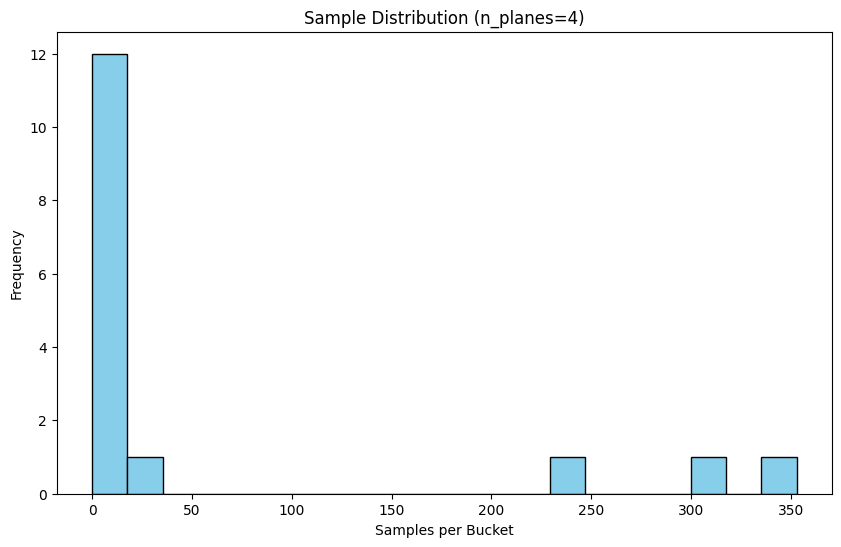

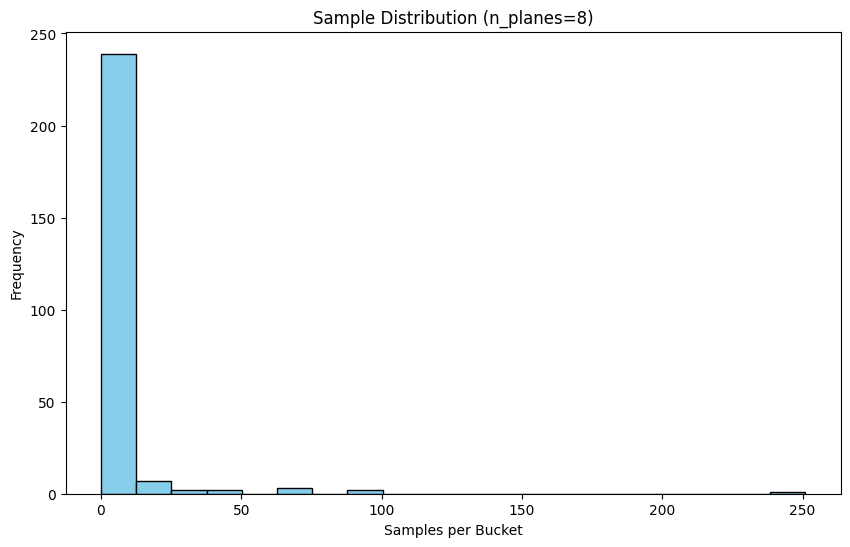

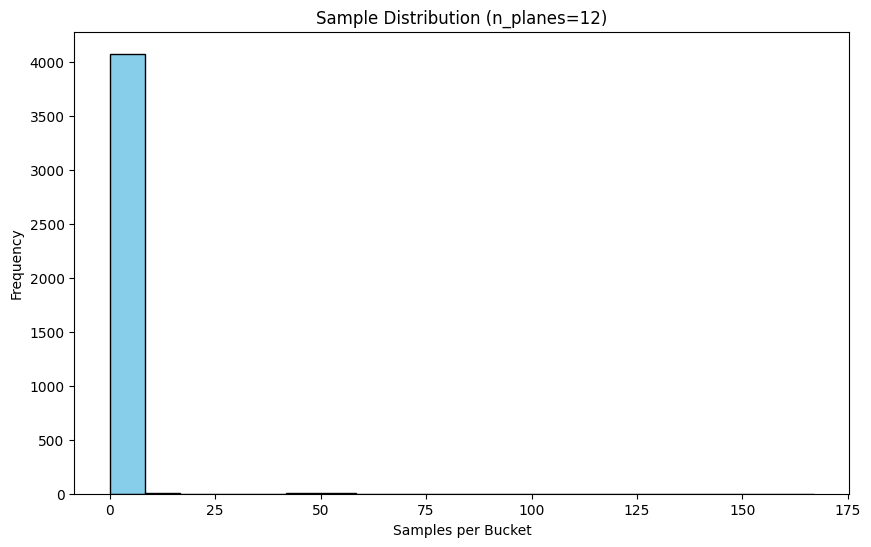

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class LSHHist:
    def __init__(self, n_planes, dim):
        self.n_planes = n_planes
        self.dim = dim
        self.planes = np.random.randn(dim, n_planes) 
        self.buckets = {"".join(map(str, b)): [] for b in self._get_bins(n_planes)}
        self.idx = 0

    def _get_bins(self, n):
        total = 1 << n
        return [list(map(int, bin(i)[2:].zfill(n))) for i in range(total)]

    def _hash_vec(self, vec):
        signs = np.dot(vec, self.planes) > 0
        return "".join(map(str, signs.astype(int)))

    def add(self, vec):
        hash_code = self._hash_vec(vec)
        self.buckets[hash_code].append(self.idx)
        self.idx += 1

    def plot(self):
        bucket_sizes = [len(vals) for vals in self.buckets.values()]
        plt.figure(figsize=(10, 6))
        plt.hist(bucket_sizes, bins=20, color='skyblue', edgecolor='black')
        plt.xlabel('Samples per Bucket')
        plt.ylabel('Frequency')
        plt.title(f'Sample Distribution (n_planes={self.n_planes})')
        plt.show()

np.random.seed(42)
data = np.random.rand(1000, 10) 

for n_planes in [4, 8, 12]:
    lsh = LSHHist(n_planes=n_planes, dim=10)
    for vec in data:
        lsh.add(vec)
    lsh.plot()


In [11]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class LSH:
    def __init__(self, nplanes, dim):
        self.nplanes = nplanes
        self.dim = dim
        self.plane_norms = np.random.randn(dim, nplanes)
        self.buckets = {}

    def _hash(self, vec):
        direction = np.dot(vec, self.plane_norms) > 0
        return "".join(map(str, direction.astype(int)))

    def add(self, vec, idx):
        hash_code = self._hash(vec)
        if hash_code not in self.buckets:
            self.buckets[hash_code] = []
        self.buckets[hash_code].append(idx)

    def retrieve_cand(self, vec):
        hash_code = self._hash(vec)
        return self.buckets.get(hash_code, [])

train_embeddings = torch.load('train_embeddings.pth').numpy()
train_labels = torch.load('train_labels.pth').numpy()
test_embeddings = torch.load('test_embeddings.pth').numpy()
test_labels = torch.load('test_labels.pth').numpy()

nplanes = 12
lsh = LSH(nplanes=nplanes, dim=train_embeddings.shape[1])

for i, vec in enumerate(train_embeddings):
    lsh.add(vec, i)

k = 100
retrieved_labels = []
true_labels = []

precision_at_100 = []
hit_rate_count = 0
mrr_list = []

for test_vec, test_label in zip(test_embeddings, test_labels):
    candidates = lsh.retrieve_cand(test_vec)
    if len(candidates) < k:
        extra_indices = np.random.choice(len(train_embeddings), size=k - len(candidates), replace=False)
        candidates.extend(extra_indices)
    
    cand_vecs = train_embeddings[candidates]
    similarities = cosine_similarity([test_vec], cand_vecs).flatten()

    top_k_indices = np.argsort(similarities)[-k:]
    top_k_labels = train_labels[candidates][top_k_indices]

    retrieved_labels.append(top_k_labels)
    true_labels.append(test_label)

    precision_at_100.append(np.sum(top_k_labels == test_label) / k)

    if test_label in top_k_labels:
        hit_rate_count += 1

    rank = np.where(top_k_labels == test_label)[0]
    if len(rank) > 0:
        mrr_list.append(1 / (rank[0] + 1))  
    else:
        mrr_list.append(0)

mean_precision = np.mean(precision_at_100)
mean_recall = np.mean([np.sum(retrieved == true) / np.sum(train_labels == true) for retrieved, true in zip(retrieved_labels, true_labels)])
mean_mrr = np.mean(mrr_list)
hit_rate = hit_rate_count / len(test_labels)


print(f"Mean Reciprocal Rank (MRR): {mean_mrr}")
print(f"Precision@100: {mean_precision}")
print(f"Hit Rate: {hit_rate}")


Mean Reciprocal Rank (MRR): 0.6692514381880846
Precision@100: 0.6740999999999999
Hit Rate: 0.999


In [38]:
n_planes = [8, 12, 16, 20]

for nbits in n_planes:
    lsh = LSH(nplanes=nbits, dim=train_embeddings.shape[1])

    for i, vec in enumerate(train_embeddings):
        lsh.add_to_buckets(vec, i)

    k = 100
    retrieved_labels = []
    true_labels = []

    precision_at_100 = []
    hit_rate_count = 0
    mrr_list = []

    for test_vec, test_label in zip(test_embeddings, test_labels):
        candidate_indices = lsh.retrieve_candidates(test_vec)
        if len(candidate_indices) < k:
            additional_indices = np.random.choice(
                len(train_embeddings), size=k - len(candidate_indices), replace=False
            )
            candidate_indices.extend(additional_indices)

        candidates = train_embeddings[candidate_indices]
        similarities = cosine_similarity([test_vec], candidates).flatten()

        top_k_indices = np.argsort(similarities)[-k:]
        top_k_labels = train_labels[candidate_indices][top_k_indices]

        retrieved_labels.append(top_k_labels)
        true_labels.append(test_label)

        precision_at_100.append(np.sum(top_k_labels == test_label) / k)

        if test_label in top_k_labels:
            hit_rate_count += 1

        rank = np.where(top_k_labels == test_label)[0]
        if len(rank) > 0:
            mrr_list.append(1 / (rank[0] + 1))  
        else:
            mrr_list.append(0)

    mean_precision = np.mean(precision_at_100)
    mean_recall = np.mean([np.sum(retrieved == true) / np.sum(train_labels == true) for retrieved, true in zip(retrieved_labels, true_labels)])
    mean_mrr = np.mean(mrr_list)
    hit_rate = hit_rate_count / len(test_labels)

    print(f"Results for {nbits} hyperplanes:")
    print(f"Mean Reciprocal Rank (MRR): {mean_mrr}")
    print(f"Precision@100: {mean_precision}")
    print(f"Hit Rate: {hit_rate}\n")

Results for 8 hyperplanes:
Mean Reciprocal Rank (MRR): 0.7213163789350423
Precision@100: 0.7151430000000001
Hit Rate: 0.9988

Results for 12 hyperplanes:
Mean Reciprocal Rank (MRR): 0.7081812198187221
Precision@100: 0.704511
Hit Rate: 0.9982

Results for 16 hyperplanes:
Mean Reciprocal Rank (MRR): 0.4944585769473964
Precision@100: 0.552036
Hit Rate: 0.9983

Results for 20 hyperplanes:
Mean Reciprocal Rank (MRR): 0.08291677855068474
Precision@100: 0.20889300000000002
Hit Rate: 0.999



#  3.3 IVF

Building IVF index with 10 clusters...


c:\Users\vpold\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


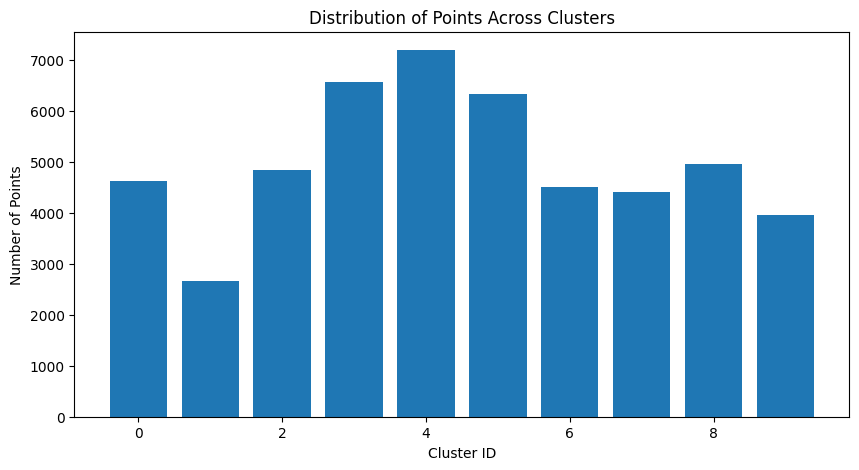


Evaluating with nprobe = 2


100%|██████████| 10000/10000 [02:43<00:00, 61.00it/s]



Evaluating with nprobe = 3


100%|██████████| 10000/10000 [04:01<00:00, 41.38it/s]



Evaluating with nprobe = 5


100%|██████████| 10000/10000 [06:39<00:00, 25.06it/s]



Evaluating with nprobe = 10


100%|██████████| 10000/10000 [13:08<00:00, 12.68it/s]


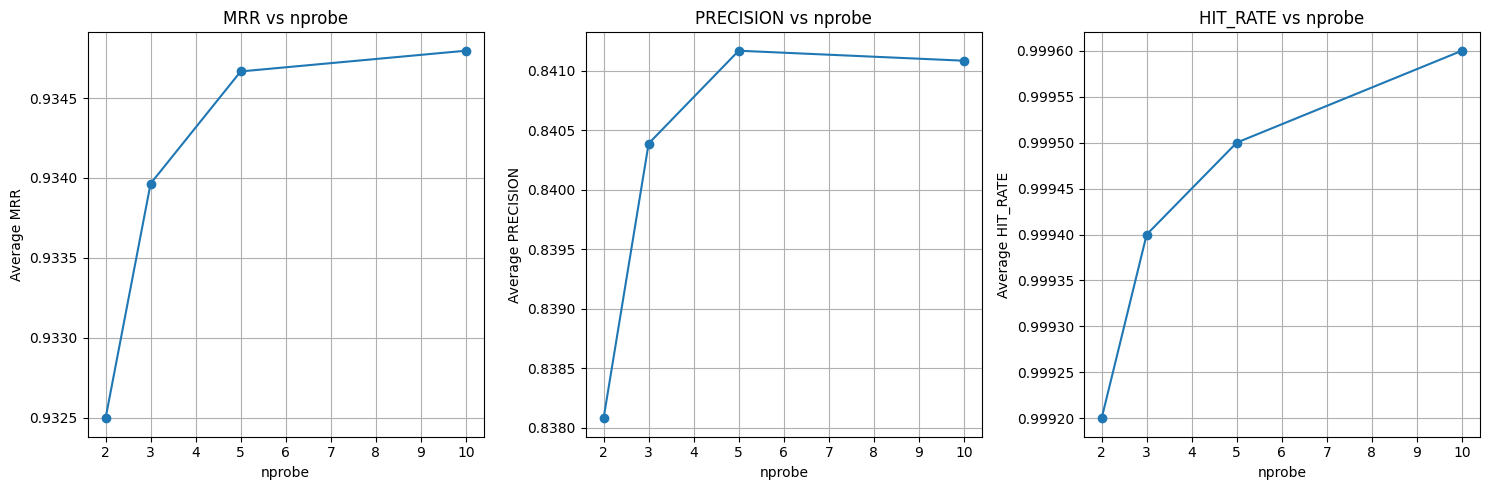

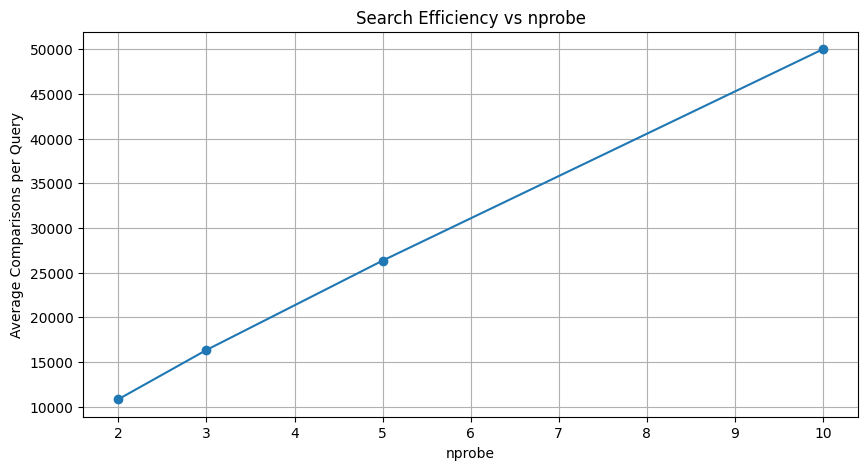


Average Metrics:
nprobe	MRR	Precision@100	Hit Rate	Comparisons
------------------------------------------------------------
2	0.9325	0.8381	0.9992	10817.4
3	0.9340	0.8404	0.9994	16327.1
5	0.9347	0.8412	0.9995	26332.6
10	0.9348	0.8411	0.9996	50000.0


In [17]:
import numpy as np
import torch
from sklearn.cluster import KMeans
from collections import defaultdict
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from tqdm import tqdm

class IVFIndex:
    def __init__(self, n_clusters: int = 10):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.index: Dict[int, List[Tuple[int, np.ndarray]]] = defaultdict(list)
        self.centroids = None
        
    def fit(self, embeddings: torch.Tensor):
        features = embeddings.cpu().numpy()
        features = features / np.linalg.norm(features, axis=1, keepdims=True)
        self.kmeans.fit(features)
        self.centroids = self.kmeans.cluster_centers_

        cluster_assignments = self.kmeans.predict(features)

        for idx, (cluster_id, vector) in enumerate(zip(cluster_assignments, features)):
            self.index[cluster_id].append((idx, vector))
            
        return self
    
    def search(self, query: np.ndarray, k: int = 100, nprobe: int = 1) -> Tuple[List[int], int]:
        query = query / np.linalg.norm(query)

        similarities = np.dot(self.centroids, query)
        closest_clusters = np.argsort(similarities)[-nprobe:]
        
        candidates = []
        n_comparisons = 0
        
        for cluster_id in closest_clusters:
            cluster_vectors = self.index[cluster_id]
            n_comparisons += len(cluster_vectors)
            
            for idx, vector in cluster_vectors:
                similarity = np.dot(vector, query)
                candidates.append((similarity, idx))
        
        candidates.sort(reverse=True)
        return [idx for _, idx in candidates[:k]], n_comparisons

def calculate_metrics(retrieved_indices: np.ndarray, 
                     query_label: int, 
                     train_labels: torch.Tensor,
                     k: int = 100) -> Dict[str, float]:
   
    train_labels_np = train_labels.cpu().numpy()
    
    retrieved_labels = train_labels_np[retrieved_indices]
    
    first_relevant = np.where(retrieved_labels == query_label)[0]
    mrr = 1.0 / (first_relevant[0] + 1) if len(first_relevant) > 0 else 0
   
    precision = np.mean(retrieved_labels == query_label)
    
    hit_rate = 1.0 if np.any(retrieved_labels == query_label) else 0.0
    
    return {
        'mrr': mrr,
        'precision': precision,
        'hit_rate': hit_rate
    }

def evaluate_retrieval(train_embeddings: torch.Tensor,
                      test_embeddings: torch.Tensor,
                      train_labels: torch.Tensor,
                      test_labels: torch.Tensor,
                      n_clusters: int = 10,
                      k: int = 100,
                      nprobe_values: List[int] = None):
    
    if nprobe_values is None:
        nprobe_values = [1, 2, 3, 5, 10]

    results = {
        'mrr': defaultdict(list),
        'precision': defaultdict(list),
        'hit_rate': defaultdict(list),
        'comparisons': defaultdict(list)
    }

    print(f"Building IVF index with {n_clusters} clusters...")
    ivf = IVFIndex(n_clusters=n_clusters)
    ivf.fit(train_embeddings)

    cluster_sizes = [len(ivf.index[i]) for i in range(ivf.n_clusters)]
    plt.figure(figsize=(10, 5))
    plt.bar(range(ivf.n_clusters), cluster_sizes)
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Points')
    plt.title('Distribution of Points Across Clusters')
    plt.show()
  
    for nprobe in nprobe_values:
        print(f"\nEvaluating with nprobe = {nprobe}")
  
        for i in tqdm(range(len(test_embeddings))):
            query = test_embeddings[i].cpu().numpy()
            query_label = test_labels[i].item()
          
            retrieved_indices, n_comparisons = ivf.search(query, k=k, nprobe=nprobe)
      
            metrics = calculate_metrics(
                retrieved_indices, 
                query_label,
                train_labels,
                k
            )
       
            results['mrr'][nprobe].append(metrics['mrr'])
            results['precision'][nprobe].append(metrics['precision'])
            results['hit_rate'][nprobe].append(metrics['hit_rate'])
            results['comparisons'][nprobe].append(n_comparisons)
    
    plt.figure(figsize=(15, 5))
    
    # Plot -MRR, Precision, and Hit Rate
    metrics_to_plot = ['mrr', 'precision', 'hit_rate']
    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(1, 3, i)
        values = [np.mean(results[metric][nprobe]) for nprobe in nprobe_values]
        plt.plot(nprobe_values, values, marker='o')
        plt.xlabel('nprobe')
        plt.ylabel(f'Average {metric.upper()}')
        plt.title(f'{metric.upper()} vs nprobe')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Plot -average comparisons
    plt.figure(figsize=(10, 5))
    avg_comparisons = [np.mean(results['comparisons'][nprobe]) for nprobe in nprobe_values]
    plt.plot(nprobe_values, avg_comparisons, marker='o')
    plt.xlabel('nprobe')
    plt.ylabel('Average Comparisons per Query')
    plt.title('Search Efficiency vs nprobe')
    plt.grid(True)
    plt.show()
    
    # average metrics for each nprobe value
    print("\nAverage Metrics:")
    print("nprobe\tMRR\tPrecision@100\tHit Rate\tComparisons")
    print("-" * 60)
    for nprobe in nprobe_values:
        print(f"{nprobe}\t{np.mean(results['mrr'][nprobe]):.4f}\t"
              f"{np.mean(results['precision'][nprobe]):.4f}\t"
              f"{np.mean(results['hit_rate'][nprobe]):.4f}\t"
              f"{np.mean(results['comparisons'][nprobe]):.1f}")
    
    return results

def main():

    train_embeddings = torch.load('train_embeddings.pth')
    train_labels = torch.load('train_labels.pth')
    test_embeddings = torch.load('test_embeddings.pth')
    test_labels = torch.load('test_labels.pth')
  
    results = evaluate_retrieval(
        train_embeddings=train_embeddings,
        test_embeddings=test_embeddings,
        train_labels=train_labels,
        test_labels=test_labels,
        n_clusters=10,
        k=100,
        nprobe_values=[2, 3, 5, 10]
    )

if __name__ == "__main__":
    main()

# 3.4 Analysis

Image to Image Retrieval Metrics: {'mean_reciprocal_rank': 0.11791054527719327, 'precision_at_k': 0.100355, 'hit_rate': 0.293}
Results for 8 hyperplanes:
Mean Reciprocal Rank (MRR): 0.6679881382682241
Precision@100: 0.669484
Hit Rate: 0.9971



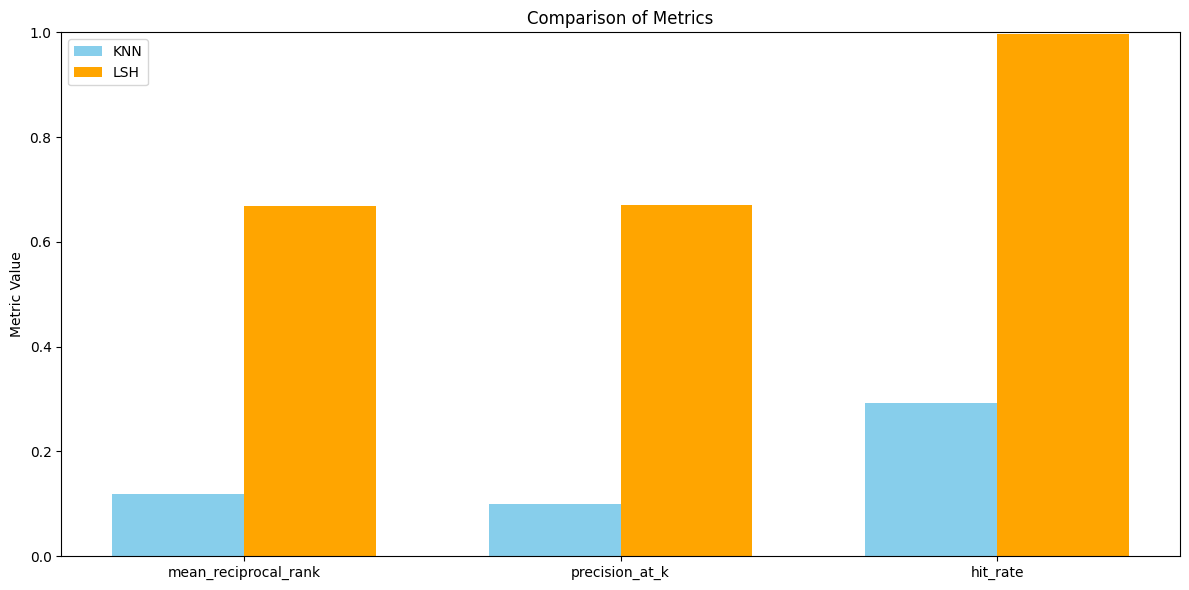

In [15]:
image_metrics = retrieval.image_to_image(k=100, method='cosine')
print("Image to Image Retrieval Metrics:", image_metrics)

train_embeddings = torch.load('train_embeddings.pth').numpy()
train_labels = torch.load('train_labels.pth').numpy()
test_embeddings = torch.load('test_embeddings.pth').numpy()
test_labels = torch.load('test_labels.pth').numpy()

nplanes = 8
lsh = LSH(nplanes=nplanes, dim=train_embeddings.shape[1])

for i, vec in enumerate(train_embeddings):
    lsh.add(vec, i)

k = 100
retrieved_labels = []
true_labels = []

precision_at_100 = []
hit_rate_count = 0
mrr_list = []

for test_vec, test_label in zip(test_embeddings, test_labels):
    candidate_indices = lsh.retrieve_cand(test_vec)
    if len(candidate_indices) < k:
        additional_indices = np.random.choice(
            len(train_embeddings), size=k - len(candidate_indices), replace=False
        )
        candidate_indices.extend(additional_indices)

    candidates = train_embeddings[candidate_indices]
    similarities = cosine_similarity([test_vec], candidates).flatten()

    top_k_indices = np.argsort(similarities)[-k:]
    top_k_labels = train_labels[candidate_indices][top_k_indices]

    retrieved_labels.append(top_k_labels)
    true_labels.append(test_label)

    precision_at_100.append(np.sum(top_k_labels == test_label) / k)

    if test_label in top_k_labels:
        hit_rate_count += 1

    rank = np.where(top_k_labels == test_label)[0]
    if len(rank) > 0:
        mrr_list.append(1 / (rank[0] + 1))  
    else:
        mrr_list.append(0)

mean_precision = np.mean(precision_at_100)
mean_mrr = np.mean(mrr_list)
hit_rate = hit_rate_count / len(test_labels)

lsh_metrics = {"MRR": mean_mrr, "Precision@100": mean_precision, "Hit Rate": hit_rate}

print(f"Results for {nplanes} hyperplanes:")
print(f"Mean Reciprocal Rank (MRR): {mean_mrr}")
print(f"Precision@100: {mean_precision}")
print(f"Hit Rate: {hit_rate}\n")

labels = list(image_metrics.keys())
image_values = list(image_metrics.values())
lsh_values = list(lsh_metrics.values())

x = np.arange(len(labels))  
width = 0.35  

plt.figure(figsize=(12, 6))
plt.bar(x - width / 2, image_values, width, label='KNN', color='skyblue')
plt.bar(x + width / 2, lsh_values, width, label='LSH', color='orange')

plt.ylabel('Metric Value')
plt.title('Comparison of Metrics')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


Building IVF index with 10 clusters...


c:\Users\vpold\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


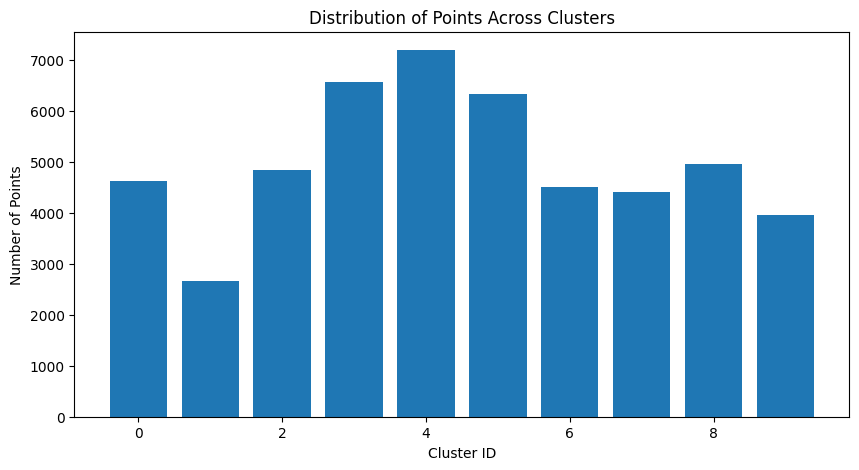


Evaluating with nprobe = 10


100%|██████████| 10000/10000 [42:11<00:00,  3.95it/s]   


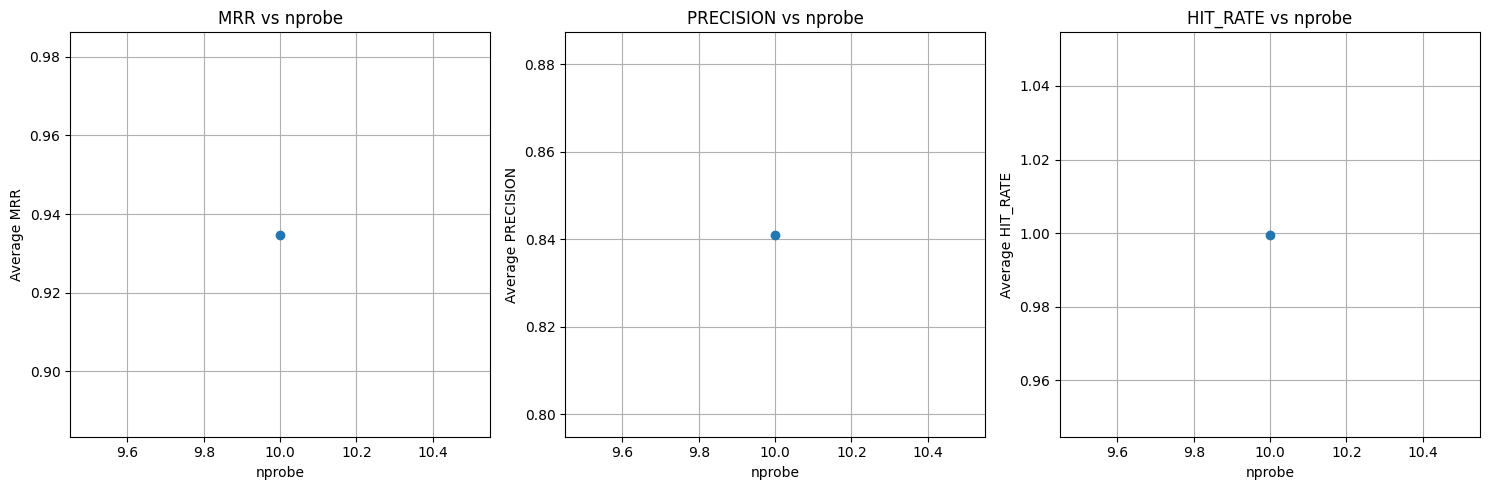

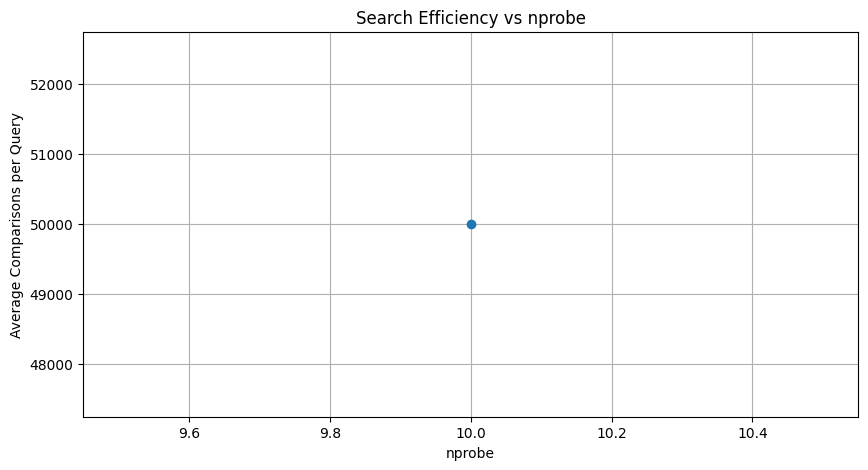


Average Metrics:
nprobe	MRR	Precision@100	Hit Rate	Comparisons
------------------------------------------------------------
10	0.9348	0.8411	0.9996	50000.0
Metrics for nprobe=10:
MRR: 0.9348
Precision@100: 0.8411
Hit Rate: 0.9996
Image to Image Retrieval Metrics: {'mean_reciprocal_rank': 0.11791054527719327, 'precision_at_k': 0.100355, 'hit_rate': 0.293}
Results for 8 hyperplanes:
Mean Reciprocal Rank (MRR): 0.7689176251106582
Precision@100: 0.7495949999999999
Hit Rate: 0.9988



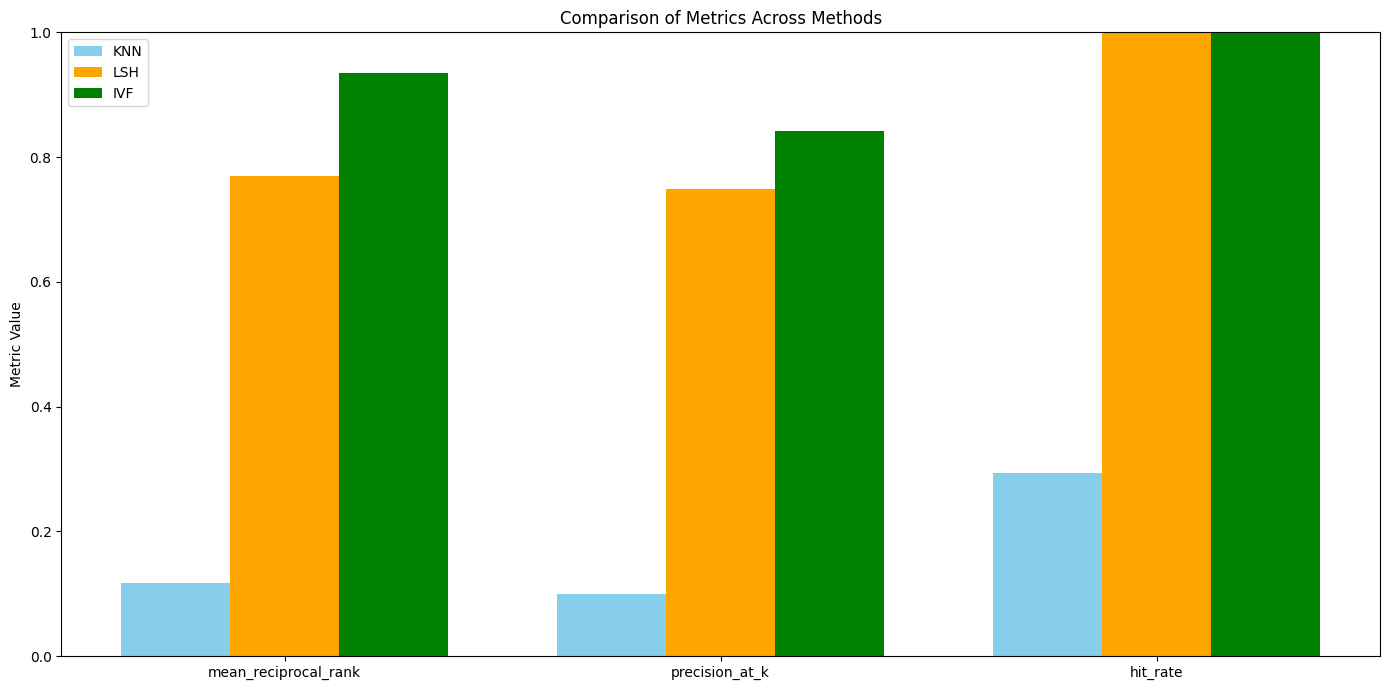

In [18]:

train_embeddings_ivf = torch.load('train_embeddings.pth')
train_labels_ivf = torch.load('train_labels.pth')
test_embeddings_ivf = torch.load('test_embeddings.pth')
test_labels_ivf = torch.load('test_labels.pth')
results = evaluate_retrieval(
    train_embeddings=train_embeddings_ivf,
    test_embeddings=test_embeddings_ivf,
    train_labels=train_labels_ivf,
    test_labels=test_labels_ivf,
    n_clusters=10,
    k=100,
    nprobe_values=[10]
)

nprobe = 10
mrr_avg = np.mean(results['mrr'][nprobe])
precision_avg = np.mean(results['precision'][nprobe])
hit_rate_avg = np.mean(results['hit_rate'][nprobe])

print(f"Metrics for nprobe={nprobe}:")
print(f"MRR: {mrr_avg:.4f}")
print(f"Precision@100: {precision_avg:.4f}")
print(f"Hit Rate: {hit_rate_avg:.4f}")

retrieval_metrics = {
    "MRR": mrr_avg,
    "Precision@100": precision_avg,
    "Hit Rate": hit_rate_avg,
}

image_metrics = retrieval.image_to_image(k=100, method='cosine')
print("Image to Image Retrieval Metrics:", image_metrics)

train_embeddings = torch.load('train_embeddings.pth').numpy()
train_labels = torch.load('train_labels.pth').numpy()
test_embeddings = torch.load('test_embeddings.pth').numpy()
test_labels = torch.load('test_labels.pth').numpy()

nplanes = 8
lsh = LSH(nplanes=nplanes, dim=train_embeddings.shape[1])

for i, vec in enumerate(train_embeddings):
    lsh.add(vec, i)

k = 100
retrieved_labels = []
true_labels = []

precision_at_100 = []
hit_rate_count = 0
mrr_list = []

for test_vec, test_label in zip(test_embeddings, test_labels):
    candidate_indices = lsh.retrieve_cand(test_vec)
    if len(candidate_indices) < k:
        additional_indices = np.random.choice(
            len(train_embeddings), size=k - len(candidate_indices), replace=False
        )
        candidate_indices.extend(additional_indices)

    candidates = train_embeddings[candidate_indices]
    similarities = cosine_similarity([test_vec], candidates).flatten()

    top_k_indices = np.argsort(similarities)[-k:]
    top_k_labels = train_labels[candidate_indices][top_k_indices]

    retrieved_labels.append(top_k_labels)
    true_labels.append(test_label)

    precision_at_100.append(np.sum(top_k_labels == test_label) / k)

    if test_label in top_k_labels:
        hit_rate_count += 1

    rank = np.where(top_k_labels == test_label)[0]
    if len(rank) > 0:
        mrr_list.append(1 / (rank[0] + 1))  
    else:
        mrr_list.append(0)

mean_precision = np.mean(precision_at_100)
mean_mrr = np.mean(mrr_list)
hit_rate = hit_rate_count / len(test_labels)

lsh_metrics = {"MRR": mean_mrr, "Precision@100": mean_precision, "Hit Rate": hit_rate}

print(f"Results for {nplanes} hyperplanes:")
print(f"Mean Reciprocal Rank (MRR): {mean_mrr}")
print(f"Precision@100: {mean_precision}")
print(f"Hit Rate: {hit_rate}\n")


labels = list(image_metrics.keys())
image_values = list(image_metrics.values())
lsh_values = list(lsh_metrics.values())
retrieval_values = list(retrieval_metrics.values())

x = np.arange(len(labels))  
width = 0.25  

plt.figure(figsize=(14, 7))
plt.bar(x - width, image_values, width, label='KNN', color='skyblue')
plt.bar(x, lsh_values, width, label='LSH', color='orange')
plt.bar(x + width, retrieval_values, width, label='IVF', color='green')

plt.ylabel('Metric Value')
plt.title('Comparison of Metrics Across Methods')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


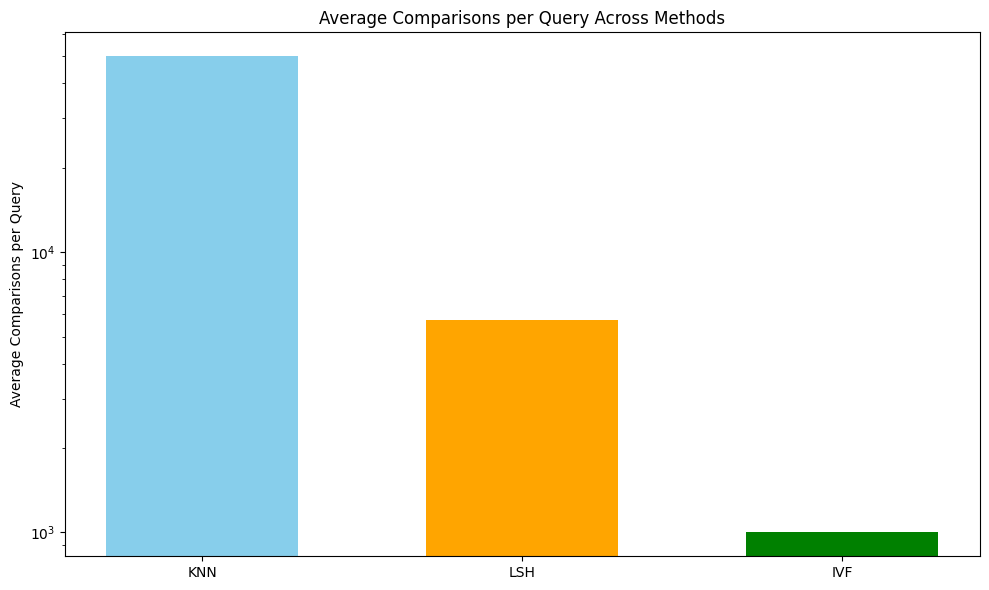

In [19]:
import matplotlib.pyplot as plt
import numpy as np

n_clusters = 100
nprobe = 10
knn_comparisons = len(train_embeddings) 
lsh_comparisons = np.mean([len(lsh.retrieve_cand(vec)) for vec in test_embeddings]) 
ivf_comparisons = n_clusters * nprobe  

comparison_metrics = {
    "KNN": knn_comparisons,
    "LSH": lsh_comparisons,
    "IVF": ivf_comparisons,
}

methods = list(comparison_metrics.keys())
comparisons = list(comparison_metrics.values())

plt.figure(figsize=(10, 6))
plt.bar(methods, comparisons, color=['skyblue', 'orange', 'green'], width=0.6)
plt.ylabel('Average Comparisons per Query')
plt.title('Average Comparisons per Query Across Methods')
plt.yscale('log')
plt.tight_layout()
plt.show()
